#Задание

Берем отызывы за лето (из архива с материалами или предыдущего занятия)
1. Учим conv сеть для классификации
2. Рассмотреть 2-а варианта сеточек
2.1 Инициализировать tf.keras.layers.Embedding предобученными векторами взять к примеру с https://rusvectores.org/ru/
2.2 Инициализировать слой tf.keras.layers.Embedding по умолчанию (ну то есть вам ничего не делать с весами)

Сравнить две архитектуры с предобученными весами и когда tf.keras.layers.Embedding обучается сразу со всей сеточкой, что получилось лучше

In [78]:
import pandas as pd
from string import punctuation
import re
import nltk
from sklearn.model_selection import train_test_split

In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
path = '/content/drive/MyDrive/Colab Notebooks/GB/Introduction to Natural Language Processing/lesson_6/отзывы за лето.xls'

In [81]:
df = pd.read_excel(path)

In [82]:
df.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [83]:
df.groupby('Rating')['Content'].nunique()

Rating
1    2252
2     748
3     909
4    1900
5    9224
Name: Content, dtype: int64

#Предобработка

In [84]:
# !pip install stop_words

In [85]:
# !pip install pymorphy2

In [86]:
from stop_words import get_stop_words

In [87]:
from pymorphy2 import MorphAnalyzer

In [88]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df['Content'] = df['Content'].apply(preprocess_text)

После предобработки заметил что есть комментарии на английском, по хорошему необходимо в них тоже подчистить стопслова. Посмотрю рез-ты и возможно вернусь к этому.

Отфильтруем данные

и соберём в корпус N наиболее частых токенов

In [269]:
max_words = 200
max_len = 40
num_classes = 5

# Training
epochs = 20
batch_size = 256
print_batch_n = 100

In [237]:
X_train, X_test, y_train, y_test = train_test_split(df['Content'], df['Rating'], shuffle=True)

In [238]:
train_corpus = " ".join(X_train)
train_corpus = train_corpus.lower()

In [239]:
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [240]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [241]:
from nltk.probability import FreqDist
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [242]:
tokens_filtered_top[:10]

['приложение',
 'удобно',
 'работать',
 'удобный',
 'отлично',
 'нравиться',
 'хороший',
 'отличный',
 'телефон',
 'супер']

In [243]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [244]:
import numpy as np

def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [245]:
X_train = np.asarray([text_to_sequence(text, max_len) for text in X_train], dtype=np.int32)
X_test = np.asarray([text_to_sequence(text, max_len) for text in X_test], dtype=np.int32)

In [219]:
X_train.shape

(15494, 40)

In [220]:
max_len

40

In [194]:
X_train[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 3], dtype=int32)

#2 Инициализировать слой tf.keras.layers.Embedding по умолчанию (ну то есть вам ничего не делать с весами)

# Keras model

In [195]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard 
# from keras.objectives import categorical_crossentropy
from tensorflow.keras.metrics import categorical_crossentropy
from keras.callbacks import EarlyStopping 
from tensorflow.keras.utils import to_categorical

In [196]:
from sklearn import model_selection, preprocessing, linear_model

In [250]:
y_train = [itm-1 for itm in y_train]
y_test = [itm-1 for itm in y_test]

In [251]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [276]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [277]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [281]:
# tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
# early_stopping=EarlyStopping(monitor='val_loss')

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    # callbacks=[tensorboard, early_stopping]
                    )

Epoch 1/20
55/55 [==============================] - 1s 12ms/step - loss: 0.7463 - accuracy: 0.7458 - val_loss: 0.7038 - val_accuracy: 0.7639
Epoch 2/20
55/55 [==============================] - 1s 11ms/step - loss: 0.6930 - accuracy: 0.7666 - val_loss: 0.6883 - val_accuracy: 0.7626
Epoch 3/20
55/55 [==============================] - 1s 11ms/step - loss: 0.6735 - accuracy: 0.7694 - val_loss: 0.6860 - val_accuracy: 0.7632
Epoch 4/20
55/55 [==============================] - 1s 10ms/step - loss: 0.6598 - accuracy: 0.7722 - val_loss: 0.6778 - val_accuracy: 0.7671
Epoch 5/20
55/55 [==============================] - 1s 10ms/step - loss: 0.6479 - accuracy: 0.7771 - val_loss: 0.6737 - val_accuracy: 0.7697
Epoch 6/20
55/55 [==============================] - 1s 11ms/step - loss: 0.6396 - accuracy: 0.7797 - val_loss: 0.6705 - val_accuracy: 0.7710
Epoch 7/20
55/55 [==============================] - 1s 10ms/step - loss: 0.6308 - accuracy: 0.7825 - val_loss: 0.6676 - val_accuracy: 0.7690
Epoch 8/20
55

In [282]:
import matplotlib.pyplot as plt

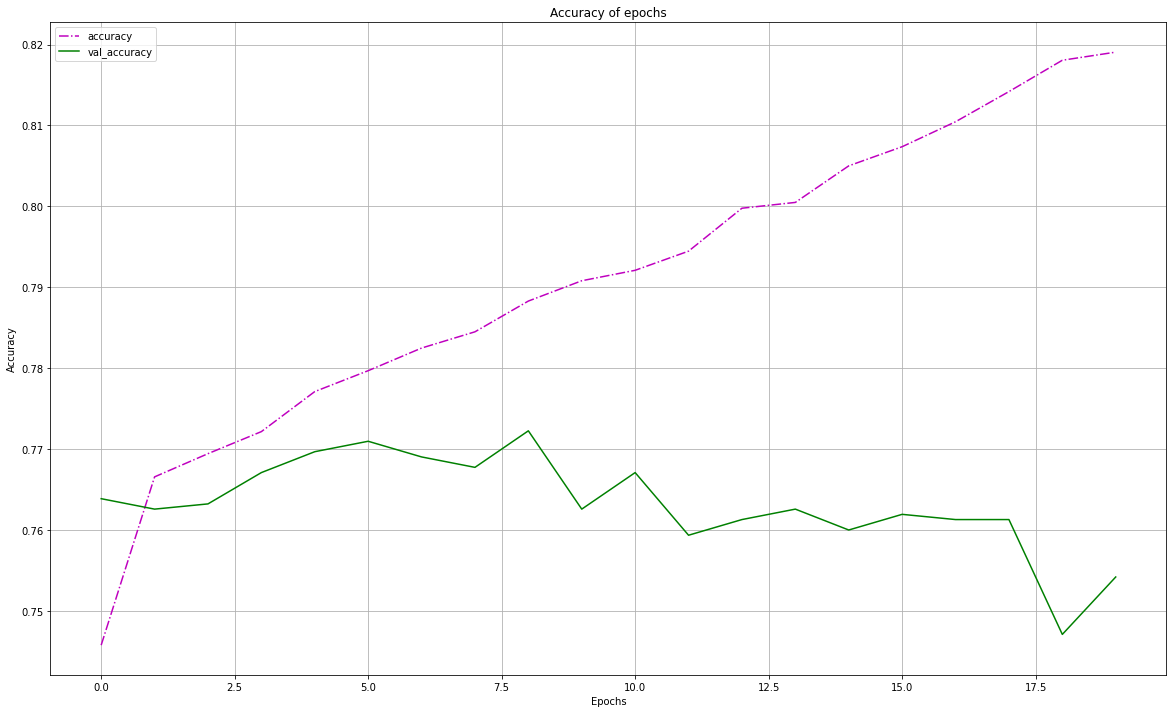

In [324]:
plt.figure(figsize=(20,12))
plt.plot(history.history['accuracy'], '-.', label = f'accuracy', color='m')
plt.plot(history.history['val_accuracy'], '-', label = f'val_accuracy', color='g')
        
plt.legend()
plt.grid('On')
plt.title('Accuracy of epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [284]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.7386397123336792
Test accuracy: 0.7502419948577881


#1. Инициализировать tf.keras.layers.Embedding предобученными векторами взять к примеру с https://rusvectores.org/ru/

In [326]:
from gensim.models import KeyedVectors

In [327]:
ru_w2v = KeyedVectors.load_word2vec_format('https://rusvectores.org/static/models/news_upos_cbow_300_2_2017.bin.gz', binary=True)

In [328]:
ru_w2v